# EDA

## Load libraries and read in pickles

In [62]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import sklearn.metrics

In [63]:
c_df = pd.read_pickle('./c_df.pkl')

In [64]:
c_df = c_df.reset_index()
c_df.drop(columns='index', inplace=True)

## Make minor changes to data

In [65]:
# lower case all cities / performer_genres
c_df['performer_genre'] = c_df['performer_genre'].apply(lambda x: str.lower(x))
# c_df['venue_city'] = c_df['venue_city'].apply(lambda x: str.lower(x))


In [66]:
# Remove all performer genres with less than 10 count
c_df = c_df[c_df.performer_genre != 'rnb']
c_df = c_df[c_df.performer_genre != 'jazz']
c_df = c_df[c_df.performer_genre != 'techno']
c_df = c_df[c_df.performer_genre != 'folk']
c_df = c_df[c_df.performer_genre != 'reggae']

In [67]:
# Combine hard rock with rock
c_df.performer_genre.replace('hard rock', 'rock', inplace=True)

In [68]:
# Change cities into region (Upstate NY, New York City, Long Island)
# Add cities into NYC which consists of the 5 boroughs
c_df['venue_region'] = c_df.venue_city.replace(['New York', 'Brooklyn', 'Staten Island', 'Forest Hills',
                                                'Flushing', 'Elmhurst', 'Maspeth'], 'new york city')
# Add cities into upstate region
c_df['venue_region'].replace(['Buffalo', 'Pawling', 'Albany', 'Port Chester', 'Ithaca',
                                               'Rochester', 'Syracuse', 'Tarrytown', 'Clifton Park',
                                               'Poughkeepsie', 'Verona', 'Saratoga Springs', 'Niagara Falls',
                                               'Darien Center', 'Canandaigua', 'Geneva', 'Lewiston', 'Hudson',
                                               'Schenectady', 'Corning', 'Binghamton', 'Woodstock',
                                               'Cooperstown', 'Liverpool', 'North Tonawanda',
                              'Niagra Falls', 'Bethel', 'Kingston'], 'upstate',
                                              inplace=True)

#Add cities into Long Island region
c_df.venue_region.replace(['Westbury', 'Huntington', 'Wantagh', 'Greenvale', 'Uniondale',
                                               'Farmingville'], 'long island', inplace=True)

c_df.venue_city = c_df.venue_city.apply(lambda x: str(x).lower())


In [69]:
#Drop all venue scores == 0
c_df = c_df[c_df['venue_score']!=0]
c_df.reset_index(drop=True)
c_df.head()

,average_price,highest_price,lowest_price,performer_genre,ticket_listing_count,venue_city,event_month,event_day,event_start,time_of_day,wkend_wkday,venue_capacity,venue_score,venue_region
0,337.0,584.0,253.0,rock,4.0,brooklyn,02,Fri,19,evening,weekend,small,0.431162,new york city
1,337.0,584.0,253.0,electronic,4.0,new york,02,Fri,19,evening,weekend,small,0.455722,new york city
2,22.0,24.0,20.0,rock,3.0,port chester,02,Fri,20,evening,weekend,large_venue,0.636922,upstate
3,45.0,80.0,30.0,pop,4.0,westbury,02,Fri,20,evening,weekend,large_venue,0.501232,long island
4,92.0,120.0,71.0,alternative,10.0,new york,02,Fri,20,evening,weekend,XL_venue,0.681791,new york city


## Exploring with data visualizations

### Number of genres

- Pop by far has a lot more around 600.
- The rest of the genres hover <100.

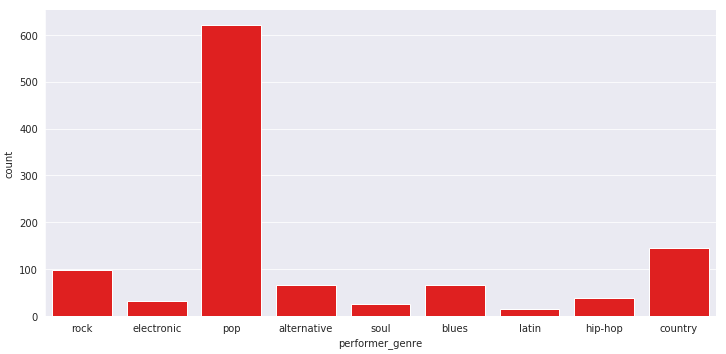

In [71]:
# Bar graph histogram of performer genres
with sns.axes_style('darkgrid'):
    g = sns.catplot("performer_genre", data=c_df, aspect=2,
                       kind="count", color='red')
    g.set_xticklabels(step=1)

### Number of Events by Region

- NYC around 600 events
- Upstate around 300 events
- Long island around 100 events

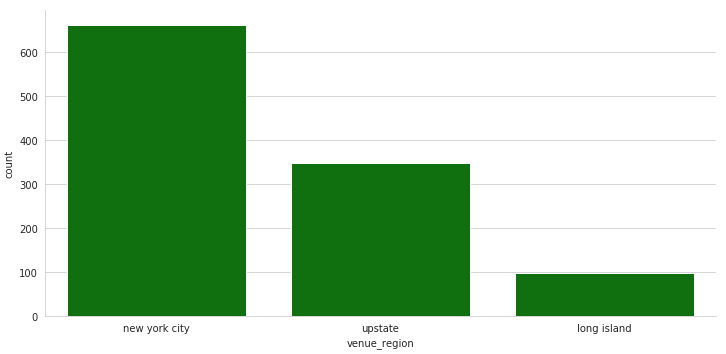

In [72]:
# Bar graph histogram of performer genres
## NYC by far has the most
with sns.axes_style('whitegrid'):
    g = sns.catplot("venue_region", data=c_df, aspect=2,
                       kind="count", color='green')
    g.set_xticklabels(step=1)

## Examining Average Price by Month

*<font color=black>This box plot shows that in August, the average price is generally the highest. <br> There are barely any events in November. <br> In March, the prices are sporadic and contain outliers prices with the minimum around \\$100 and the highest \\$1750.</font>*

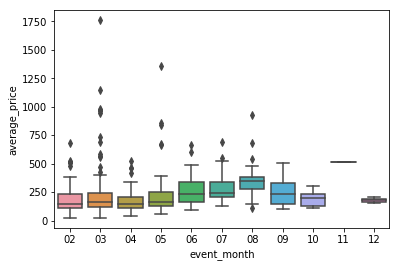

In [11]:
sns.boxplot(x="event_month", y="average_price", data=c_df)

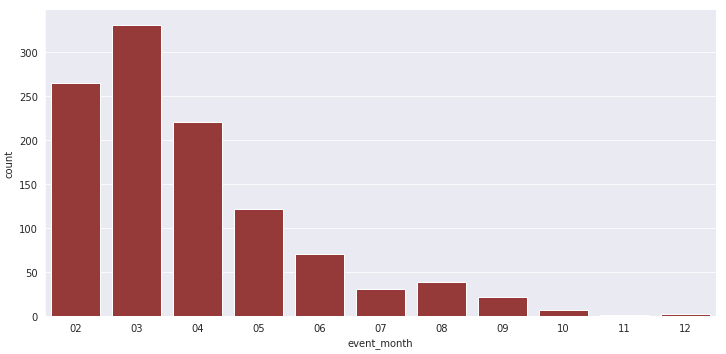

In [75]:
# Bar graph histogram of event_months
with sns.axes_style('darkgrid'):
    g = sns.catplot("event_month", data=c_df, aspect=2,
                       kind="count", color='brown')
    g.set_xticklabels(step=1)
# we have a lot more events between february and april

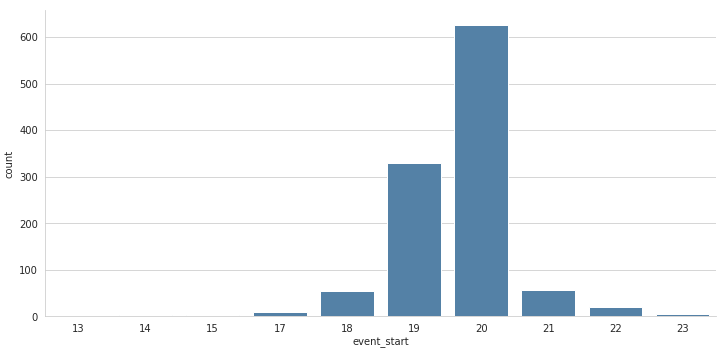

In [14]:
# Bar graph histogram of start times
with sns.axes_style('whitegrid'):
    g = sns.catplot("event_start", data=c_df, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=1)

## Exploring pricing

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c22f51e80>],
      dtype=object)

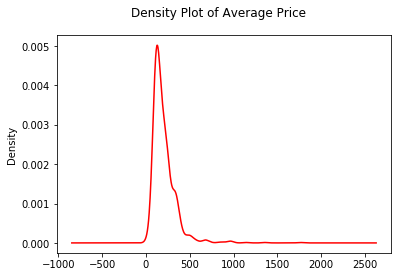

In [80]:
c_df['average_price'].plot(kind='density', title='Density Plot of Average Price', color='red', subplots=True)

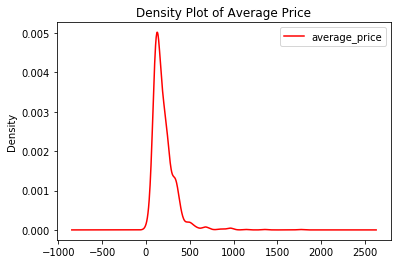

In [83]:
c_df['average_price'].plot(kind='density', title='Density Plot of Average Price', color='red',legend=True)

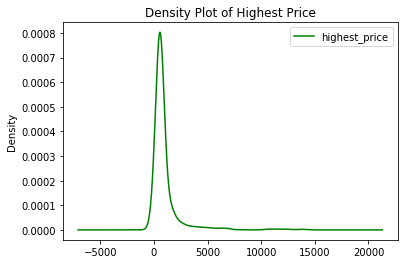

In [84]:
c_df['highest_price'].plot(kind='density', title='Density Plot of Highest Price', color='Green', legend=True)

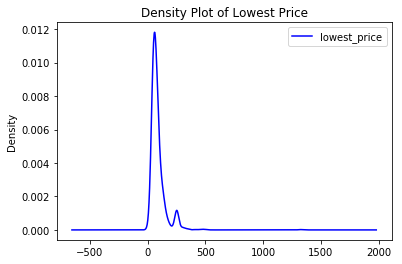

In [85]:
c_df['lowest_price'].plot(kind='density', title='Density Plot of Lowest Price', color='blue', legend=True)

<br>

## Prep to make dummy dataframe

###  Create feature dataframe

In [15]:
c_df.columns

Index(['average_price', 'highest_price', 'lowest_price', 'performer_genre',
       'ticket_listing_count', 'venue_city', 'event_month', 'event_day',
       'event_start', 'time_of_day', 'wkend_wkday', 'venue_capacity',
       'venue_score', 'venue_region'],
      dtype='object')

In [16]:
# Drop venue city because feature engineered venue region // venue_score
# c_df.drop(columns=['venue_score'],inplace=True)
c_df_features = pd.DataFrame(c_df, columns=['highest_price', 'lowest_price', 'performer_genre',
                                            'ticket_listing_count', 'venue_city', 'event_month', 'event_day',
                                            'event_start', 'time_of_day', 'wkend_wkday', 'venue_capacity',
                                            'venue_region', 'venue_score'])

In [17]:
c_df_features = c_df_features.reset_index(drop=True)

###  Create target dataframe

In [18]:
c_df_target = pd.DataFrame(c_df, columns=['average_price'])
c_df_target = c_df_target.reset_index(drop=True)

In [19]:
list(c_df_features)[0:10]

['highest_price',
 'lowest_price',
 'performer_genre',
 'ticket_listing_count',
 'venue_city',
 'event_month',
 'event_day',
 'event_start',
 'time_of_day',
 'wkend_wkday']

<br>

## Multicollineraity

In [57]:
corr = c_df_features.corr()
abs(corr) >  .75
#None are too correlated

,highest_price,lowest_price,ticket_listing_count,event_start,venue_score
highest_price,True,False,False,False,False
lowest_price,False,True,False,False,False
ticket_listing_count,False,False,True,False,False
event_start,False,False,False,True,False
venue_score,False,False,False,False,True


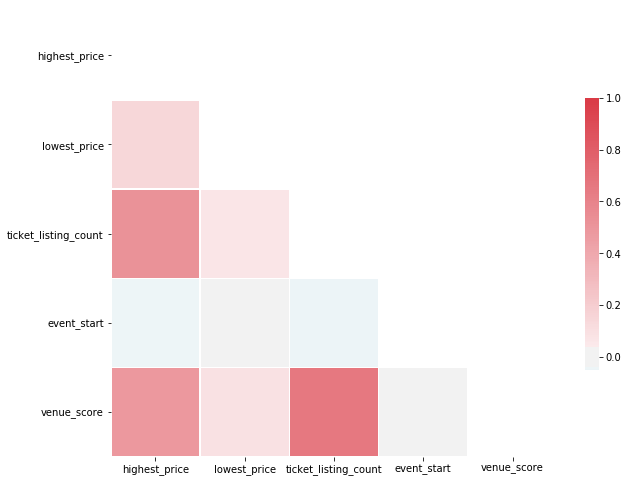

In [59]:
# can also look at heat maps to see correlation. don't want variables that have colors at 
# either spectrum
mask = np.zeros_like(corr, dtype=np.bool)
cmap = sns.diverging_palette(220, 10, as_cmap=True) #sets the color
mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#ticket listing count and venue score maybe highly correlated because venue score depends on how well the venue sells their tickets

In [29]:
c_df.drop(columns = ['venue_city'], inplace=True)

In [31]:
c_df = pd.get_dummies(c_df, columns=['performer_genre',\
                              'event_month','event_day'\
                              ,'time_of_day','wkend_wkday', 'event_start',\
                             'venue_capacity', 'venue_region'])

In [32]:
#Pickle everything with dummy values
c_df.to_pickle('./c_df_dummies.pkl')